# Sentiment Classification Using RNNs

* Given the IMDB Movie Review Dataset, create an RNN model that predicts whether the given review is negative or positive.
* You need to create your Dataset, Dataloader and Model. Keep your code modular and avoid hardcoding any parameter. This will allow you to experiment more easily.
* Plot graphs for loss and accuracy for each epoch of a training loop. Try using wandb for logging training and validation losses, accuracies.
* Use tqdm to keep track of the status of the training loop for an epoch

### 1. RNN Model
#### 1.1 Build a Dataset from the IMDB Movie Review Dataset by taking reviews with word count between 100 and 500. Perform text processing on the movie reviews and create a word to index mapping for representing any review as a list of numbers.
#### 1.2 Create Dataloaders for the train, test and validation datasets with appropriate batch sizes.
#### 1.3 Create the Model class for the RNN Model. Create functions for running model training and testing.

In [1]:
from datasets import load_dataset
from nltk.stem import PorterStemmer
import contractions
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchtext.vocab import build_vocab_from_iterator, Vocab
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, random_split
import random
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score
random_seed = 123
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)


/home2/chowdam.v/kumar/kumar_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the IMDb dataset
imdb_dataset = load_dataset("imdb")

In [3]:
def pre_process(text, stemming=False):
    t = contractions.fix(text) 
    t = re.sub(r'[^\w\s]', ' ', t) 
    t = re.sub(r'\s+', ' ', t)
    if stemming:
        stemmer = PorterStemmer()
        t = " ".join(stemmer.stem(word) for word in t.split())
    t = re.sub(r'\b\d+\b', '<num>', t)
    return t.lower()

In [4]:
UNKNOWN_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"

class IMDBDataset(Dataset):
  def __init__(self, data, vocabulary_words:Vocab|None=None, stemming=False):
    """Initialize the dataset. Setup Code goes here"""
      
    self.sentences_original = [example['text'] for example in data]
    self.labels_original = [example['label'] for example in data]

    self.sentences = []
    self.labels = []
      
    for sentence,label in zip(self.sentences_original,self.labels_original):
        sentence = pre_process(sentence, stemming=stemming).split()
        if 100 <= len(sentence) <= 500:
            self.sentences.append(sentence)
            self.labels.append(label)

    if vocabulary_words is None:
      self.vocabulary_words = build_vocab_from_iterator(self.sentences, specials=[PAD_TOKEN, UNKNOWN_TOKEN])
      self.vocabulary_words.set_default_index(self.vocabulary_words[UNKNOWN_TOKEN])
    else:
      self.vocabulary_words = vocabulary_words

  def __len__(self) -> int:
    """Returns number of datapoints."""
    return len(self.sentences)

  def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
    """Get the datapoint at `index`."""
    return torch.tensor(self.vocabulary_words.lookup_indices(self.sentences[index])), torch.tensor(self.labels[index])

  def collate(self, batch: list[tuple[torch.Tensor, torch.Tensor]]) -> tuple[torch.Tensor, torch.Tensor]:
    """Given a list of datapoints, batch them together"""
    sentences = [i[0] for i in batch]
    labels = [i[1] for i in batch]

    features = np.zeros((len(sentences), 500),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)
    padded_sentences = torch.tensor(features)
    # padded_sentences = pad_sequence(sentences, batch_first=True, padding_value=self.vocabulary_words[PAD_TOKEN])
    # if padded_sentences.size(1) < 500:
    #   padded_sentences = torch.cat([padded_sentences, torch.full((padded_sentences.size(0), 500 - padded_sentences.size(1)), self.vocabulary_words[PAD_TOKEN])], dim=1)
    padded_labels = torch.tensor(labels)
    return padded_sentences, padded_labels


In [5]:
dataset = IMDBDataset(imdb_dataset['train'])
test_dataset = IMDBDataset(imdb_dataset['test'],vocabulary_words=dataset.vocabulary_words)


In [23]:
train_size, val_size = 0.8, 0.2
batch_size = 64

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=dataset.collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=dataset.collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=dataset.collate)

In [66]:

class RNNModel(nn.Module):
    def __init__(self, vocab_size, num_classes, hidden_size, num_layers, bidirectionality=False, embedding_dim=256, rnn_type='rnn', what_to_pick='last'):
        super(RNNModel, self).__init__()
        self.bidirectionality = bidirectionality
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type
        self.what_to_pick = what_to_pick
        
        if self.rnn_type == 'rnn':
            self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=bidirectionality)
        elif self.rnn_type == 'lstm':
            self.rnn = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=bidirectionality)
            
        self.dropout = nn.Dropout(0.2)
        if self.bidirectionality:
            self.fc = nn.Linear(hidden_size * 2, num_classes)
        else:
            self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        out, _ = self.rnn(embedded)
        if self.what_to_pick == 'last':
            out = out[:, -1]  
        else:
            out = torch.mean(out, dim=1)
        out = self.dropout(out)
        out = self.fc(out)
        out = self.sigmoid(out)
        return out.squeeze() 
        
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.path = path

    def __call__(self, score, model):

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(score, model)
        elif score < self.best_score - self.delta:
            self.best_score = score
            self.save_checkpoint(score, model)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, score, model):
        torch.save(model.state_dict(), self.path)


In [52]:
def train(model, model_name, n_epochs=25):
  val_accuracies_epoch_wise = []
  train_loss_epoch_wise = []
  val_loss_epoch_wise = []
  device = "cuda" if torch.cuda.is_available() else "cpu"
  # device =  "cpu"
  print("Utilising",device)
  loss_fn = torch.nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  # optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

  model = model.to(device)
  model_path = 'models/sentiment_'+model_name+".pt"
  early_stopping = EarlyStopping(patience=5, path=model_path)

  for epoch_num in range(n_epochs):
      model.train()
      epoch_loss = 0

      progress_bar = tqdm(train_loader, desc=f"Epoch {epoch_num}", total=len(train_loader))

      for batch_num, (words, tags) in enumerate(progress_bar):
          (words, tags) = (words.to(device), tags.to(device))
          optimizer.zero_grad()
          pred = model(words)
          loss = loss_fn(pred, tags.float())
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
          progress_bar.set_postfix({'loss': loss.item()})

      epoch_loss /= len(train_loader)
      train_loss_epoch_wise.append(epoch_loss)
      model.eval()

      with torch.no_grad():
        val_loss = 0
        all_predictions = []
        all_ground_truth = []
        for batch_num, (words, tags) in enumerate(val_loader):
            (words, tags) = (words.to(device), tags.to(device))
            pred = model(words)
            val_loss += loss_fn(pred, tags.float()).item()
            predictions = (pred >= 0.5).int().cpu().numpy()
            ground_truth = tags.cpu().numpy()
            all_predictions += list(predictions)
            all_ground_truth += list(ground_truth)

        accuracy_val = accuracy_score(all_ground_truth, all_predictions)
        val_accuracies_epoch_wise.append( accuracy_val*100)
          
        val_loss /= len(val_loader)
        val_loss_epoch_wise.append(val_loss)

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping....")
            break

      if epoch_num % 1 == 0:
          print(f"Epoch {epoch_num}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
  print("best val loss is",early_stopping.best_score)
  return train_loss_epoch_wise, val_loss_epoch_wise, val_accuracies_epoch_wise

def test(model, model_name):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  print("Utilising",device)
  # device =  "cpu"
  model = model.to(device)
  model_path = 'models/sentiment_'+model_name+".pt"
  state_dict = torch.load(model_path)
  model.load_state_dict(state_dict)
  model.eval()

  with torch.no_grad():
    all_predictions = []
    all_ground_truth = []
    for batch_num, (words, tags) in enumerate(val_loader):
        (words, tags) = (words.to(device), tags.to(device))
        pred = model(words)
        predictions = (pred >= 0.5).int().cpu().numpy()
        ground_truth = tags.cpu().numpy()
        all_predictions += list(predictions)
        all_ground_truth += list(ground_truth)

    accuracy_val = accuracy_score(all_ground_truth, all_predictions)

    all_predictions = []
    all_ground_truth = []
    for batch_num, (words, tags) in enumerate(test_loader):
        (words, tags) = (words.to(device), tags.to(device))
        pred = model(words)
        predictions = (pred >= 0.5).int().cpu().numpy()
        ground_truth = tags.cpu().numpy().flatten()
        all_predictions.append(predictions)
        all_ground_truth.append(ground_truth)
    all_predictions = np.concatenate(all_predictions)
    all_ground_truth = np.concatenate(all_ground_truth)

    accuracy_test = accuracy_score(all_ground_truth, all_predictions)

    return accuracy_val, accuracy_test

In [53]:
model_name =  'main_rnn'
embedding_dim = 512
hidden_layers = 2
hidden_dim = 768
bidirectionality = False
model = RNNModel(len(dataset.vocabulary_words), 1, hidden_dim, hidden_layers,bidirectionality=bidirectionality, embedding_dim=embedding_dim, rnn_type='rnn')
train_loss_epoch_wise, val_loss_epoch_wise, val_accuracies_epoch_wise = train(model, model_name, n_epochs=20)
accuracy_val, accuracy_test = test(model, model_name)

Utilising cuda


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.06it/s, loss=0.656]


Epoch 0, Train Loss: 0.6640, Val Loss: 0.6457


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.03it/s, loss=0.498]


Epoch 1, Train Loss: 0.5874, Val Loss: 0.5674


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.03it/s, loss=0.64]


Epoch 2, Train Loss: 0.5438, Val Loss: 0.5994


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:21<00:00, 11.91it/s, loss=0.652]


Epoch 3, Train Loss: 0.5143, Val Loss: 0.6409


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.00it/s, loss=0.458]


Epoch 4, Train Loss: 0.5164, Val Loss: 0.6061


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.02it/s, loss=0.478]


Epoch 5, Train Loss: 0.4907, Val Loss: 0.5887


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 11.96it/s, loss=0.519]


Early stopping....
best val loss is 0.5674418736071813
Utilising cuda


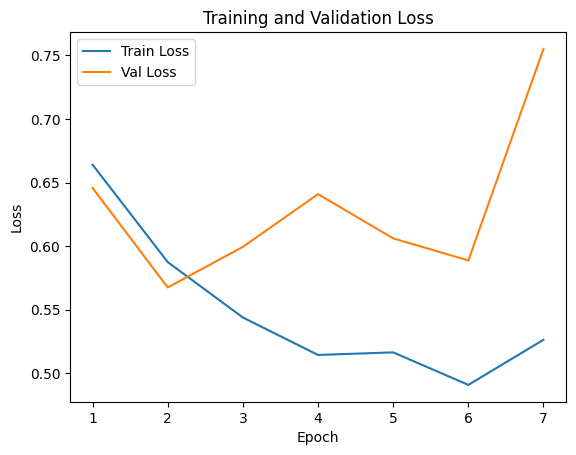

In [55]:
# plot training and validation losses
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_loss_epoch_wise)+1), train_loss_epoch_wise, label='Train Loss')
plt.plot(range(1, len(train_loss_epoch_wise)+1), val_loss_epoch_wise, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

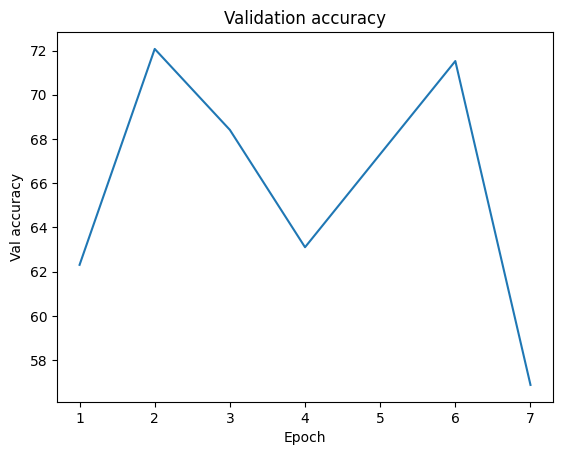

In [56]:
# plot validation accuracy
plt.plot(range(1, len(val_accuracies_epoch_wise)+1), val_accuracies_epoch_wise, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Val accuracy')
plt.title('Validation accuracy')
plt.show()

In [59]:
# find the classification accuracy on test set
print(f"Final Validation accuracy is {accuracy_val*100}")
print(f"Final Test accuracy is {accuracy_test*100}")


Final Validation accuracy is 72.07274539113104
Final Test accuracy is 71.86192468619247


#### 1.2 Incorporate stemming/lemmatization when doing text preprocessing using the NLTK library. What changes do you observe in accuracy ?

In [60]:
dataset = IMDBDataset(imdb_dataset['train'], stemming=True)
test_dataset = IMDBDataset(imdb_dataset['test'],vocabulary_words=dataset.vocabulary_words, stemming=True)


In [61]:
train_size, val_size = 0.8, 0.2
batch_size = 64

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=dataset.collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=dataset.collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=dataset.collate)

In [62]:
model_name =  'main_rnn_stemming'
embedding_dim = 512
hidden_layers = 2
hidden_dim = 768
bidirectionality = False
model = RNNModel(len(dataset.vocabulary_words), 1, hidden_dim, hidden_layers,bidirectionality=bidirectionality, embedding_dim=embedding_dim, rnn_type='rnn')
train_loss_epoch_wise, val_loss_epoch_wise, val_accuracies_epoch_wise = train(model, model_name, n_epochs=20)
accuracy_val, accuracy_test = test(model, model_name)

Utilising cuda


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.29it/s, loss=0.648]


Epoch 0, Train Loss: 0.6623, Val Loss: 0.6413


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.29it/s, loss=0.381]


Epoch 1, Train Loss: 0.5929, Val Loss: 0.5620


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.16it/s, loss=0.491]


Epoch 2, Train Loss: 0.5385, Val Loss: 0.5332


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.27it/s, loss=0.668]


Epoch 3, Train Loss: 0.5386, Val Loss: 0.6576


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.29it/s, loss=0.525]


Epoch 4, Train Loss: 0.5189, Val Loss: 0.6220


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.04it/s, loss=0.422]


Epoch 5, Train Loss: 0.4815, Val Loss: 0.6142


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.11it/s, loss=0.306]


Epoch 6, Train Loss: 0.4476, Val Loss: 0.5445


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.16it/s, loss=0.328]


Early stopping....
best val loss is 0.5331530372301737
Utilising cuda


In [65]:
print(f"Final Validation accuracy is {accuracy_val*100}")
print(f"Final Test accuracy is {accuracy_test*100}")
print("Accuracy improved about 3% when stemming performed in data pre-processing")

Final Validation accuracy is 75.11210762331838
Final Test accuracy is 74.96015142458657
Accuracy improved about 3% when stemming performed in data pre-processing


#### 1.3 In the Model class, experiment with only picking the last output and mean of all outputs in the RNN layer. What changes do you observe ?

In [67]:
model_name =  'main_rnn_stemming_mean'
embedding_dim = 512
hidden_layers = 2
hidden_dim = 768
bidirectionality = False
model = RNNModel(len(dataset.vocabulary_words), 1, hidden_dim, hidden_layers,bidirectionality=bidirectionality, embedding_dim=embedding_dim, rnn_type='rnn', what_to_pick='mean')
train_loss_epoch_wise, val_loss_epoch_wise, val_accuracies_epoch_wise = train(model, model_name, n_epochs=20)
accuracy_val, accuracy_test = test(model, model_name)

Utilising cuda


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.27it/s, loss=0.741]


Epoch 0, Train Loss: 0.6925, Val Loss: 0.6866


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.28it/s, loss=0.6]


Epoch 1, Train Loss: 0.5425, Val Loss: 0.4830


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.12it/s, loss=0.585]


Epoch 2, Train Loss: 0.4400, Val Loss: 0.4529


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.11it/s, loss=0.41]


Epoch 3, Train Loss: 0.3988, Val Loss: 0.4123


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.15it/s, loss=0.384]


Epoch 4, Train Loss: 0.3584, Val Loss: 0.4058


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.07it/s, loss=0.229]


Epoch 5, Train Loss: 0.3302, Val Loss: 0.3966


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.05it/s, loss=0.344]


Epoch 6, Train Loss: 0.3110, Val Loss: 0.3937


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.10it/s, loss=0.372]


Epoch 7, Train Loss: 0.2738, Val Loss: 0.3923


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.02it/s, loss=0.239]


Epoch 8, Train Loss: 0.2468, Val Loss: 0.4301


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.00it/s, loss=0.156]


Epoch 9, Train Loss: 0.2229, Val Loss: 0.3947


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.06it/s, loss=0.121]


Epoch 10, Train Loss: 0.1972, Val Loss: 0.4233


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.00it/s, loss=0.129]


Epoch 11, Train Loss: 0.1750, Val Loss: 0.3719


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.00it/s, loss=0.26]


Epoch 12, Train Loss: 0.1469, Val Loss: 0.4747


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.31it/s, loss=0.29]


Epoch 13, Train Loss: 0.1250, Val Loss: 0.4331


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.45it/s, loss=0.128]


Epoch 14, Train Loss: 0.1036, Val Loss: 0.4490


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:19<00:00, 12.63it/s, loss=0.088]


Epoch 15, Train Loss: 0.0808, Val Loss: 0.5065


Epoch 16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:19<00:00, 12.69it/s, loss=0.0741]


Early stopping....
best val loss is 0.3718691368897756
Utilising cuda


In [69]:
print(f"Final Validation accuracy is {accuracy_val*100}")
print(f"Final Test accuracy is {accuracy_test*100}")
print("Accuracy improved about 6% when picked mean instead of last layer.\nThe above models trained by picking last layer, so just performed with mean.")

Final Validation accuracy is 84.42949676133532
Final Test accuracy is 80.98226738394102
Accuracy improved about 6% when picked mean instead of last layer.
The above models trained by picking last layer, so just performed with mean.


### 2. Hyperparameter Tuning
#### 2.1 Starting with the best configurations based on the above experiments, experiment with 5 different hyperparameter configurations. You can change the size of embedding layer, hidden state, batch in the dataloader.


In [76]:
model_configs_rnn = {
    'model_1':{
        'hidden_layers':1,
        'hidden_dim':128,
        'embedding_size':128,
        'bidirectionality':False
    },
    'model_2':{
        'hidden_layers':2,
        'hidden_dim':256,
        'embedding_size':512,
        'bidirectionality':False
        },
    'model_3':{
        'hidden_layers':3,
        'hidden_dim':512,
        'embedding_size':128,
        'bidirectionality':False
    },
    'model_4':{
        'hidden_layers':7,
        'hidden_dim':256,
        'embedding_size':128,
        'bidirectionality':False
    },
    'model_5':{
        'hidden_layers':10,
        'hidden_dim':512,
        'embedding_size':512,
        'bidirectionality':False
    }
}

In [77]:
accs = []
for model_name in model_configs_rnn:
    print(f"{model_name}")
    hidden_dim = model_configs_rnn[model_name]['hidden_dim']
    hidden_layers = model_configs_rnn[model_name]['hidden_layers']
    embedding_dim = model_configs_rnn[model_name]['embedding_size']
    bidirectionality = model_configs_rnn[model_name]['bidirectionality']
    model = RNNModel(len(dataset.vocabulary_words), 1, hidden_dim, hidden_layers,bidirectionality=bidirectionality, embedding_dim=embedding_dim,rnn_type='rnn',what_to_pick='mean')
    train_loss_epoch_wise, val_loss_epoch_wise, val_accuracies_epoch_wise = train(model, 'hyp_para_tuning_'+model_name, n_epochs=20)
    accuracy_val, accuracy_test = test(model, 'hyp_para_tuning_'+model_name)
    accs.append(accuracy_test*100)
    print(f"Final Validation accuracy with {model_name} is {accuracy_val*100}")
    print(f"Final Test accuracy with {model_name} is {accuracy_test*100}")

model_1
Utilising cuda


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:03<00:00, 77.20it/s, loss=0.712]


Epoch 0, Train Loss: 0.6928, Val Loss: 0.6901


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:03<00:00, 78.42it/s, loss=0.675]


Epoch 1, Train Loss: 0.6891, Val Loss: 0.6847


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:03<00:00, 79.21it/s, loss=0.622]


Epoch 2, Train Loss: 0.6757, Val Loss: 0.6151


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:03<00:00, 79.62it/s, loss=0.557]


Epoch 3, Train Loss: 0.6033, Val Loss: 0.5819


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:03<00:00, 79.23it/s, loss=0.563]


Epoch 4, Train Loss: 0.5790, Val Loss: 0.5692


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:03<00:00, 75.35it/s, loss=0.527]


Epoch 5, Train Loss: 0.5502, Val Loss: 0.5437


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:03<00:00, 76.59it/s, loss=0.639]


Epoch 6, Train Loss: 0.5258, Val Loss: 0.5362


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:02<00:00, 92.56it/s, loss=0.487]


Epoch 7, Train Loss: 0.5057, Val Loss: 0.5181


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:02<00:00, 92.53it/s, loss=0.555]


Epoch 8, Train Loss: 0.4888, Val Loss: 0.5037


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:02<00:00, 90.95it/s, loss=0.421]


Epoch 9, Train Loss: 0.4687, Val Loss: 0.4917


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:03<00:00, 75.27it/s, loss=0.423]


Epoch 10, Train Loss: 0.4529, Val Loss: 0.4816


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:03<00:00, 77.53it/s, loss=0.389]


Epoch 11, Train Loss: 0.4379, Val Loss: 0.4782


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:03<00:00, 78.54it/s, loss=0.51]


Epoch 12, Train Loss: 0.4251, Val Loss: 0.4719


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:03<00:00, 78.04it/s, loss=0.392]


Epoch 13, Train Loss: 0.4078, Val Loss: 0.4570


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:03<00:00, 78.91it/s, loss=0.363]


Epoch 14, Train Loss: 0.3934, Val Loss: 0.4526


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:03<00:00, 79.09it/s, loss=0.465]


Epoch 15, Train Loss: 0.3832, Val Loss: 0.4609


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:03<00:00, 79.13it/s, loss=0.419]


Epoch 16, Train Loss: 0.3714, Val Loss: 0.4367


Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:03<00:00, 78.17it/s, loss=0.352]


Epoch 17, Train Loss: 0.3583, Val Loss: 0.4480


Epoch 18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:03<00:00, 73.54it/s, loss=0.33]


Epoch 18, Train Loss: 0.3479, Val Loss: 0.4598


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:03<00:00, 77.58it/s, loss=0.301]


Epoch 19, Train Loss: 0.3377, Val Loss: 0.4249
best val loss is 0.4249321543981159
Utilising cuda
Final Validation accuracy with model_1 is 81.7887394120578
Final Test accuracy with model_1 is 80.60370591751345
model_2
Utilising cuda


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:05<00:00, 47.17it/s, loss=0.678]


Epoch 0, Train Loss: 0.6911, Val Loss: 0.6732


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:05<00:00, 48.58it/s, loss=0.604]


Epoch 1, Train Loss: 0.5704, Val Loss: 0.5041


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:05<00:00, 47.76it/s, loss=0.373]


Epoch 2, Train Loss: 0.4666, Val Loss: 0.4690


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:05<00:00, 47.55it/s, loss=0.335]


Epoch 3, Train Loss: 0.4055, Val Loss: 0.4362


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:05<00:00, 47.42it/s, loss=0.348]


Epoch 4, Train Loss: 0.3654, Val Loss: 0.4279


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:05<00:00, 47.19it/s, loss=0.304]


Epoch 5, Train Loss: 0.3360, Val Loss: 0.4528


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:05<00:00, 47.56it/s, loss=0.285]


Epoch 6, Train Loss: 0.3067, Val Loss: 0.4012


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:05<00:00, 48.96it/s, loss=0.487]


Epoch 7, Train Loss: 0.2805, Val Loss: 0.4286


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:05<00:00, 48.26it/s, loss=0.278]


Epoch 8, Train Loss: 0.2576, Val Loss: 0.4331


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:05<00:00, 47.67it/s, loss=0.166]


Epoch 9, Train Loss: 0.2347, Val Loss: 0.4360


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:05<00:00, 48.07it/s, loss=0.208]


Epoch 10, Train Loss: 0.2159, Val Loss: 0.4248


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:05<00:00, 47.50it/s, loss=0.2]


Early stopping....
best val loss is 0.40118585621553754
Utilising cuda
Final Validation accuracy with model_2 is 83.25859491778775
Final Test accuracy with model_2 is 82.43674038653118
model_3
Utilising cuda


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:15<00:00, 16.54it/s, loss=0.746]


Epoch 0, Train Loss: 0.6936, Val Loss: 0.6944


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:15<00:00, 15.79it/s, loss=0.684]


Epoch 1, Train Loss: 0.6824, Val Loss: 0.6382


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:16<00:00, 15.49it/s, loss=0.631]


Epoch 2, Train Loss: 0.5974, Val Loss: 0.5348


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:15<00:00, 16.46it/s, loss=0.387]


Epoch 3, Train Loss: 0.5065, Val Loss: 0.5051


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:15<00:00, 15.74it/s, loss=0.41]


Epoch 4, Train Loss: 0.4646, Val Loss: 0.4705


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:15<00:00, 15.92it/s, loss=0.424]


Epoch 5, Train Loss: 0.4391, Val Loss: 0.4705


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:15<00:00, 16.35it/s, loss=0.335]


Epoch 6, Train Loss: 0.4173, Val Loss: 0.4472


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:15<00:00, 15.78it/s, loss=0.394]


Epoch 7, Train Loss: 0.3962, Val Loss: 0.4381


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:15<00:00, 16.51it/s, loss=0.316]


Epoch 8, Train Loss: 0.3798, Val Loss: 0.4267


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:15<00:00, 16.58it/s, loss=0.311]


Epoch 9, Train Loss: 0.3667, Val Loss: 0.4293


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:15<00:00, 16.52it/s, loss=0.361]


Epoch 10, Train Loss: 0.3488, Val Loss: 0.4163


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:15<00:00, 15.69it/s, loss=0.409]


Epoch 11, Train Loss: 0.3325, Val Loss: 0.4090


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:16<00:00, 15.61it/s, loss=0.206]


Epoch 12, Train Loss: 0.3166, Val Loss: 0.4220


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:15<00:00, 16.50it/s, loss=0.206]


Epoch 13, Train Loss: 0.3059, Val Loss: 0.4064


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:15<00:00, 16.68it/s, loss=0.424]


Epoch 14, Train Loss: 0.2931, Val Loss: 0.4077


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:14<00:00, 16.79it/s, loss=0.301]


Epoch 15, Train Loss: 0.2802, Val Loss: 0.4002


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:15<00:00, 16.66it/s, loss=0.232]


Epoch 16, Train Loss: 0.2657, Val Loss: 0.4038


Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:15<00:00, 16.43it/s, loss=0.205]


Epoch 17, Train Loss: 0.2488, Val Loss: 0.4275


Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:14<00:00, 16.73it/s, loss=0.193]


Epoch 18, Train Loss: 0.2404, Val Loss: 0.3981


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:14<00:00, 16.84it/s, loss=0.323]


Epoch 19, Train Loss: 0.2231, Val Loss: 0.4137
best val loss is 0.39812897453232415
Utilising cuda
Final Validation accuracy with model_3 is 83.70702541106128
Final Test accuracy with model_3 is 82.66088862323173
model_4
Utilising cuda


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 27.01it/s, loss=0.694]


Epoch 0, Train Loss: 0.6934, Val Loss: 0.6922


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 26.83it/s, loss=0.615]


Epoch 1, Train Loss: 0.6797, Val Loss: 0.6195


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 25.80it/s, loss=0.464]


Epoch 2, Train Loss: 0.5779, Val Loss: 0.5447


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 26.20it/s, loss=0.534]


Epoch 3, Train Loss: 0.5222, Val Loss: 0.5286


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 26.78it/s, loss=0.478]


Epoch 4, Train Loss: 0.4926, Val Loss: 0.4968


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 26.78it/s, loss=0.483]


Epoch 5, Train Loss: 0.4641, Val Loss: 0.4821


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 26.90it/s, loss=0.473]


Epoch 6, Train Loss: 0.4465, Val Loss: 0.4732


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 27.05it/s, loss=0.333]


Epoch 7, Train Loss: 0.4239, Val Loss: 0.4681


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 26.63it/s, loss=0.625]


Epoch 8, Train Loss: 0.4058, Val Loss: 0.4632


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 26.76it/s, loss=0.271]


Epoch 9, Train Loss: 0.3877, Val Loss: 0.4534


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 26.87it/s, loss=0.318]


Epoch 10, Train Loss: 0.3749, Val Loss: 0.4343


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 26.87it/s, loss=0.263]


Epoch 11, Train Loss: 0.3585, Val Loss: 0.4381


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 26.94it/s, loss=0.453]


Epoch 12, Train Loss: 0.3439, Val Loss: 0.4407


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 26.79it/s, loss=0.285]


Epoch 13, Train Loss: 0.3342, Val Loss: 0.4424


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 26.82it/s, loss=0.323]


Epoch 14, Train Loss: 0.3225, Val Loss: 0.4249


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 26.78it/s, loss=0.343]


Epoch 15, Train Loss: 0.3076, Val Loss: 0.4307


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 26.57it/s, loss=0.419]


Epoch 16, Train Loss: 0.2965, Val Loss: 0.4395


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 26.89it/s, loss=0.29]


Epoch 17, Train Loss: 0.2877, Val Loss: 0.4302


Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 26.71it/s, loss=0.185]


Epoch 18, Train Loss: 0.2761, Val Loss: 0.4248


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 26.42it/s, loss=0.347]


Epoch 19, Train Loss: 0.2650, Val Loss: 0.4272
best val loss is 0.4247560290590165
Utilising cuda
Final Validation accuracy with model_4 is 82.90981564524166
Final Test accuracy with model_4 is 81.06694560669456
model_5
Utilising cuda


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:46<00:00,  5.40it/s, loss=0.718]


Epoch 0, Train Loss: 0.6961, Val Loss: 0.6958


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:48<00:00,  5.18it/s, loss=0.704]


Epoch 1, Train Loss: 0.6979, Val Loss: 0.6930


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:48<00:00,  5.17it/s, loss=0.699]


Epoch 2, Train Loss: 0.6974, Val Loss: 0.6936


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:48<00:00,  5.15it/s, loss=0.7]


Epoch 3, Train Loss: 0.6973, Val Loss: 0.6927


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:48<00:00,  5.18it/s, loss=0.683]


Epoch 4, Train Loss: 0.6980, Val Loss: 0.6940


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:47<00:00,  5.32it/s, loss=0.692]


Epoch 5, Train Loss: 0.6973, Val Loss: 0.6927


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:47<00:00,  5.30it/s, loss=0.691]


Epoch 6, Train Loss: 0.6968, Val Loss: 0.6927


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:48<00:00,  5.18it/s, loss=0.693]


Epoch 7, Train Loss: 0.6943, Val Loss: 0.6928


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:48<00:00,  5.17it/s, loss=0.691]


Epoch 8, Train Loss: 0.6931, Val Loss: 0.6928


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:46<00:00,  5.38it/s, loss=0.691]


Epoch 9, Train Loss: 0.6930, Val Loss: 0.6926


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:47<00:00,  5.27it/s, loss=0.694]


Epoch 10, Train Loss: 0.6955, Val Loss: 0.6937


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:46<00:00,  5.39it/s, loss=0.682]


Epoch 11, Train Loss: 0.6973, Val Loss: 0.6958


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:48<00:00,  5.16it/s, loss=0.709]


Epoch 12, Train Loss: 0.6962, Val Loss: 0.6926


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:46<00:00,  5.36it/s, loss=0.684]


Epoch 13, Train Loss: 0.6966, Val Loss: 0.6945


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:48<00:00,  5.21it/s, loss=0.689]


Epoch 14, Train Loss: 0.6955, Val Loss: 0.6946


Epoch 15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:48<00:00,  5.16it/s, loss=0.69]


Epoch 15, Train Loss: 0.6964, Val Loss: 0.6933


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:47<00:00,  5.28it/s, loss=0.737]


Epoch 16, Train Loss: 0.6957, Val Loss: 0.6927


Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:46<00:00,  5.38it/s, loss=0.696]


Early stopping....
best val loss is 0.6926305852239094
Utilising cuda
Final Validation accuracy with model_5 is 51.59441953163926
Final Test accuracy with model_5 is 50.95138473799562


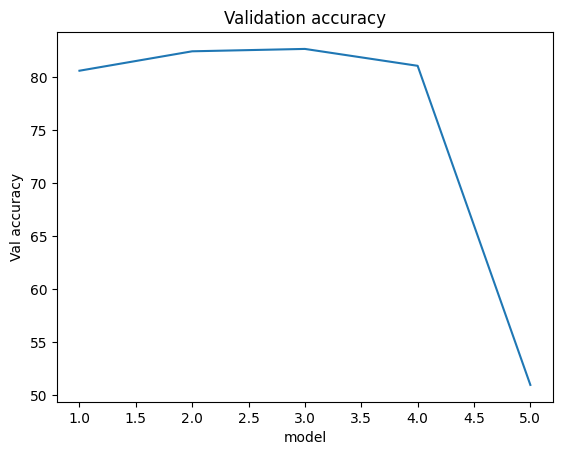

In [78]:
# plot validation accuracy
plt.plot(range(1, len(accs)+1), accs, label='Train Loss')
plt.xlabel('model')
plt.ylabel('Val accuracy')
plt.title('Validation accuracy')
plt.show()

## Observation
Model 1,2,3 and 4 are performing in similar range, whereas model 5 performed very low. Model 3 is the best configuration selected for LSTM for next part

### 3. After RNNs
#### 3.1 Keeping all the parameters same, replace the RNN layer with the LSTM layer using nn.LSTM. What changes do you observe ? Explain why LSTM layer would affect performance.

In [80]:
model_name = 'model_3'
hidden_dim = model_configs_rnn[model_name]['hidden_dim']
hidden_layers = model_configs_rnn[model_name]['hidden_layers']
embedding_dim = model_configs_rnn[model_name]['embedding_size']
bidirectionality = model_configs_rnn[model_name]['bidirectionality']
model = RNNModel(len(dataset.vocabulary_words), 1, hidden_dim, hidden_layers,bidirectionality=bidirectionality, embedding_dim=embedding_dim,rnn_type='lstm',what_to_pick='mean')
train_loss_epoch_wise, val_loss_epoch_wise, val_accuracies_epoch_wise = train(model, 'lstm_'+model_name, n_epochs=20)
accuracy_val, accuracy_test = test(model, 'lstm_'+model_name)
accs.append(accuracy_test*100)
print(f"Final Validation accuracy with {model_name} is {accuracy_val*100}")
print(f"Final Test accuracy with {model_name} is {accuracy_test*100}")

Utilising cuda


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:39<00:00,  6.37it/s, loss=0.663]


Epoch 0, Train Loss: 0.6875, Val Loss: 0.6378


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:39<00:00,  6.33it/s, loss=0.519]


Epoch 1, Train Loss: 0.5719, Val Loss: 0.5290


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:40<00:00,  6.26it/s, loss=0.482]


Epoch 2, Train Loss: 0.4845, Val Loss: 0.4825


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:40<00:00,  6.26it/s, loss=0.386]


Epoch 3, Train Loss: 0.4278, Val Loss: 0.4501


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:39<00:00,  6.30it/s, loss=0.279]


Epoch 4, Train Loss: 0.3795, Val Loss: 0.4046


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:40<00:00,  6.23it/s, loss=0.204]


Epoch 5, Train Loss: 0.3316, Val Loss: 0.3853


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:39<00:00,  6.31it/s, loss=0.282]


Epoch 6, Train Loss: 0.3013, Val Loss: 0.4015


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:40<00:00,  6.24it/s, loss=0.175]


Epoch 7, Train Loss: 0.2754, Val Loss: 0.3660


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:39<00:00,  6.28it/s, loss=0.232]


Epoch 8, Train Loss: 0.2395, Val Loss: 0.3568


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:39<00:00,  6.31it/s, loss=0.168]


Epoch 9, Train Loss: 0.2211, Val Loss: 0.3830


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:39<00:00,  6.29it/s, loss=0.179]


Epoch 10, Train Loss: 0.1991, Val Loss: 0.3597


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:40<00:00,  6.27it/s, loss=0.15]


Epoch 11, Train Loss: 0.1703, Val Loss: 0.3736


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:40<00:00,  6.26it/s, loss=0.295]


Epoch 12, Train Loss: 0.1542, Val Loss: 0.4512


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:40<00:00,  6.25it/s, loss=0.118]


Early stopping....
best val loss is 0.35679555577891214
Utilising cuda
Final Validation accuracy with model_3 is 85.27653213751869
Final Test accuracy with model_3 is 85.0916517234509


# Observation
1. With RNN same configuration as model 3, test accuracy is 82.6%
2. With LSTM same configuration as model 3, test accuracy is 85.1%
3. ~3% improvement is observed.

# Reason for LSTM performing better
1. RNN can't capture longter dependencies as the current hidden state depends on only one step previous.
2. To mitigate this disadvantage LSTM has dedicated memory cell with different gates such as forget gate, cell state, input gate and output gate. Which helps to learn to remeber longterm dependencies.
3. This is the main reason for improvement in performance.